In [1]:
#Q-5

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
from torchvision import datasets,transforms
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

In [5]:
d_train=torch.utils.data.DataLoader(datasets.CIFAR10(root='./data',train=True,download=True,transform=transforms.ToTensor()),batch_size=64)
d_test=torch.utils.data.DataLoader(datasets.CIFAR10(root='./data',train=False,download=True,transform=transforms.ToTensor()),batch_size=4)

100%|██████████| 170498071/170498071 [00:02<00:00, 83439072.01it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [10]:
d_train.dataset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [4]:
d_test.dataset

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [11]:
class CNN_wout_BN(nn.Module):
    def __init__(self):
        super(CNN_wout_BN, self).__init__()
        self.conv1=nn.Conv2d(3, 6, 5)
        self.pool=nn.MaxPool2d(2, 2)
        self.conv2=nn.Conv2d(6,16,5)
        self.pool=nn.MaxPool2d(2, 2)
        self.conv3=nn.Conv2d(16, 120, 5)
        self.fc1=nn.Linear(120, 84)
        self.fc2=nn.Linear(84, 10)

    def forward(self, x):
        x=self.pool(F.relu(self.conv1(x)))
        x=self.pool(F.relu(self.conv2(x)))
        x=F.relu(self.conv3(x))
        x=x.view(-1,120)
        x=F.relu(self.fc1(x))
        x=self.fc2(x)
        return x

In [12]:
class CNN_w_BN(nn.Module):
    def __init__(self):
        super(CNN_w_BN,self).__init__()
        self.conv1=nn.Conv2d(3, 6, 5)
        self.bn1=nn.BatchNorm2d(6)
        self.pool=nn.MaxPool2d(2, 2)
        self.conv2=nn.Conv2d(6,16,5)
        self.bn2=nn.BatchNorm2d(16)
        self.pool=nn.MaxPool2d(2, 2)
        self.conv3=nn.Conv2d(16, 120, 5)
        self.fc1=nn.Linear(120, 84)
        self.fc2=nn.Linear(84, 10)

    def forward(self, x):
        x=self.pool(F.relu(self.bn1(self.conv1(x))))
        x=self.pool(F.relu(self.bn2(self.conv2(x))))
        x=F.relu(self.conv3(x))
        x=x.view(-1,120)
        x=F.relu(self.fc1(x))
        x=self.fc2(x)
        return x

In [ ]:
model1=CNN_wout_BN()
model2=CNN_w_BN()
optim1=optim.Adam(model1.parameters(),lr=0.001)
optim2=optim.Adam(model2.parameters(),lr=0.001)
criterion=nn.CrossEntropyLoss()

device=torch.device('cuda' if torch.cuda is not None else 'cpu')
model1.to(device)
model2.to(device)

In [29]:
def train(model,optimizer,criterion,epochs):
  model.train()
  for epoch in range(epochs):
    running_loss=0
    for i,data in enumerate(d_train,0):
      inputs,labels=data
      inputs,labels=inputs.to(device),labels.to(device)
      optimizer.zero_grad()
      outputs=model(inputs)
      loss=criterion(outputs,labels)
      loss.backward()
      optimizer.step()
      running_loss+=loss.item()
    print(f'Epoch:{epoch+1},Training Loss: {running_loss/len(d_train)}')

In [21]:
train_loader=DataLoader(d_train,batch_size=64)
test_loader=DataLoader(d_test,batch_size=4)

In [39]:
train(model1,optim1,criterion,1)

Epoch:1,Training Loss: 0.7141775898540111


In [37]:
train(model2,optim2,criterion,10)

Epoch:1,Training Loss: 0.43246244504819137
Epoch:2,Training Loss: 0.4216924879004431
Epoch:3,Training Loss: 0.41076783757761615
Epoch:4,Training Loss: 0.39819162632898447
Epoch:5,Training Loss: 0.3944568328816644
Epoch:6,Training Loss: 0.3913747844812663
Epoch:7,Training Loss: 0.37942002116776335
Epoch:8,Training Loss: 0.3722585350122598
Epoch:9,Training Loss: 0.3625493985422127
Epoch:10,Training Loss: 0.34606373299132376


>Both models were run over 40 epochs.

In [84]:
def display_activations(activations,title):
    num_activations=len(activations)
    fig=plt.figure(figsize=(num_activations*2, 2))

    for i in range(num_activations):
        ax=fig.add_subplot(1,num_activations,i+1)
        ax.imshow(activations[i],aspect='auto')
        ax.axis('off')

    fig.suptitle(title)
    plt.tight_layout()
    plt.subplots_adjust(top=0.90)
    plt.show()
##Used CLAUDE for this Snippet (above)

def output_dist(activation,title):
    activation=activation.flatten()
    plt.hist(activation,bins=30,density=True)
    plt.title(title)
    plt.show()

In [46]:
d_train.dataset.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [56]:
d_train.dataset[0][0].shape

torch.Size([3, 32, 32])

In [64]:
def img_show(img,title):
  arr=img.numpy()
  plt.imshow(np.transpose(arr,(1,2,0)))
  plt.title(title)
  plt.show()

In [80]:
test_image=d_train.dataset[53][0]
test_image=test_image.to(device)
model1.eval()
model2.eval()

with torch.no_grad():
  model1_conv1_activation=model1.conv1(test_image).cpu()
  pool_11=model1.pool(F.relu(model1_conv1_activation)).cpu()
  model1_conv2_activation=model1.conv2(model1_conv1_activation.to(device)).cpu()

  model2_conv1_activation=model2.conv1(test_image).cpu()
  pool_21=model2.pool(F.relu(model2_conv1_activation)).cpu()
  model2_conv2_activation=model2.conv2(model2_conv1_activation.to(device)).cpu()

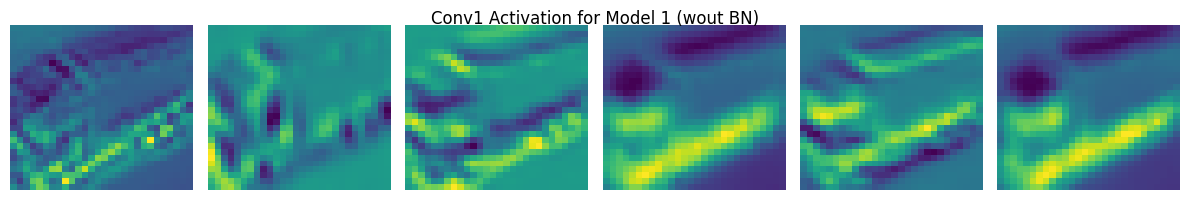

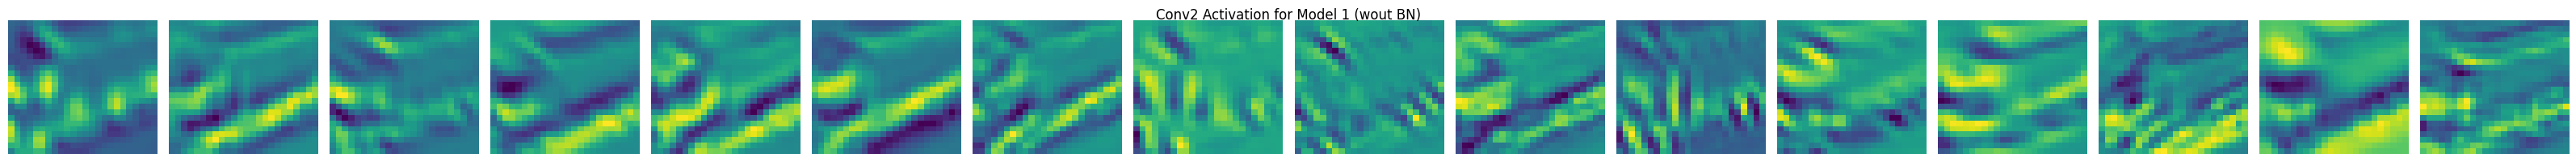

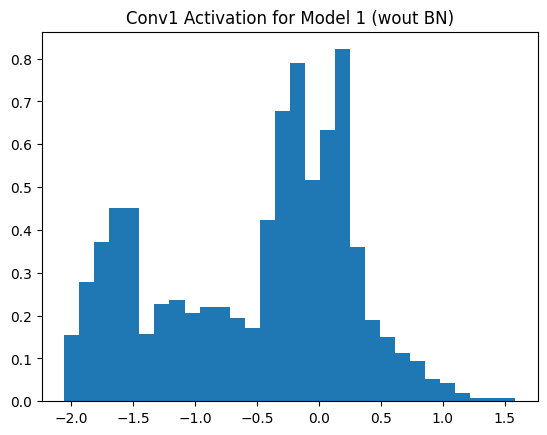

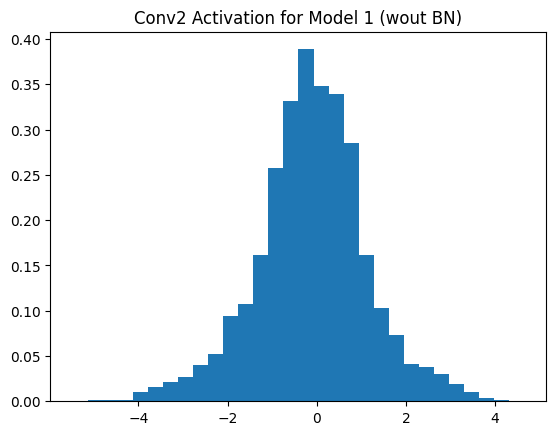

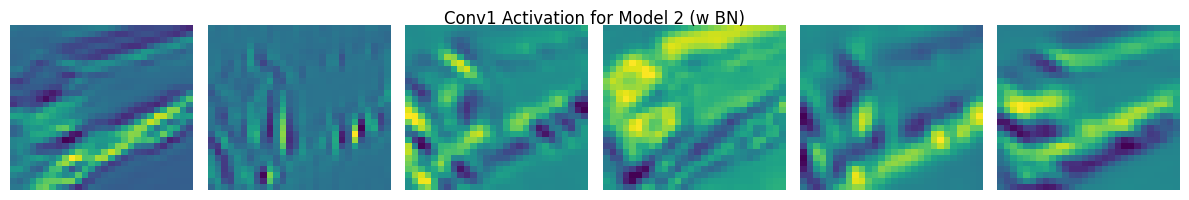

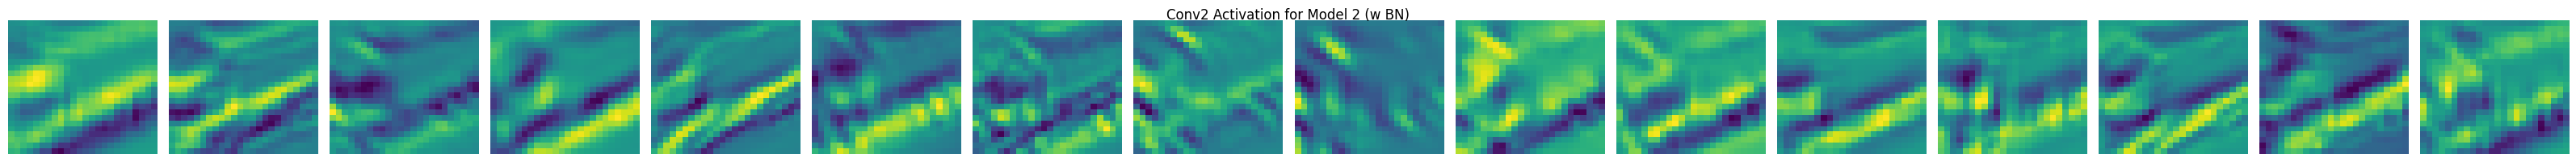

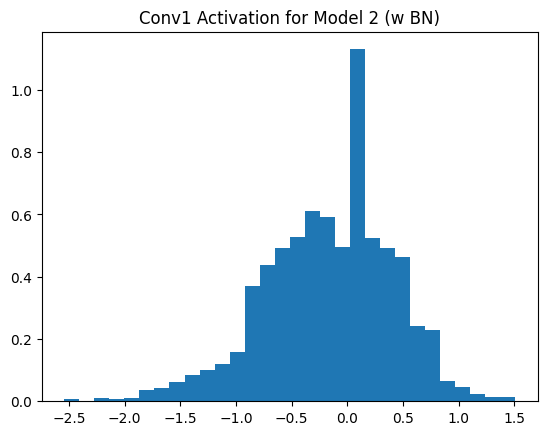

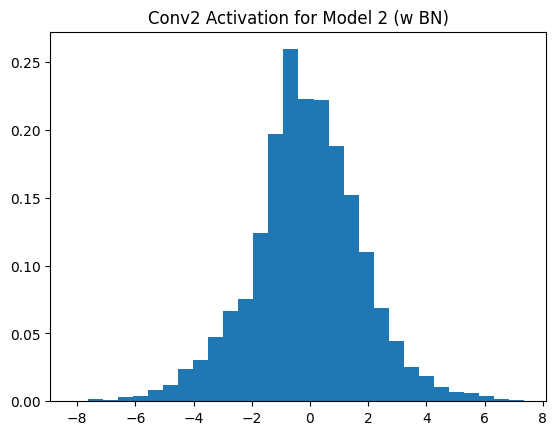

In [85]:
display_activations((model1_conv1_activation.squeeze().numpy()),'Conv1 Activation for Model 1 (wout BN)')
display_activations((model1_conv2_activation.squeeze().numpy()),'Conv2 Activation for Model 1 (wout BN)')
output_dist(model1_conv1_activation.squeeze().numpy(),'Conv1 Activation for Model 1 (wout BN)')
output_dist(model1_conv2_activation.squeeze().numpy(),'Conv2 Activation for Model 1 (wout BN)')

display_activations((model2_conv1_activation.squeeze().numpy()),'Conv1 Activation for Model 2 (w BN)')
display_activations((model2_conv2_activation.squeeze().numpy()),'Conv2 Activation for Model 2 (w BN)')
output_dist(model2_conv1_activation.squeeze().numpy(),'Conv1 Activation for Model 2 (w BN)')
output_dist(model2_conv2_activation.squeeze().numpy(),'Conv2 Activation for Model 2 (w BN)')

## *SmoothGrad*

In [18]:
def smoothgrad(model,image,label,num_samples=50,noise_level=0.15):
    smooth_grad=torch.zeros_like(image)
    image=image.unsqueeze(0) #(adding batch dimension here)
    for _ in range(num_samples):
        noise=torch.randn_like(image)*noise_level
        noisy_image=image+noise
        noisy_image.requires_grad_()
        output=model(noisy_image)
        loss=F.cross_entropy(output,torch.tensor([label]))
        model.zero_grad()
        loss.backward()
        smooth_grad+=noisy_image.grad.data.squeeze(0)
    smooth_grad /=num_samples
    return smooth_grad.squeeze().cpu().numpy()

In [19]:
images_per_class=[]
labels_per_class=[]
for i in range(10):
    for images, labels in d_test:
        for label in labels:
            if label.item()== i:
                images_per_class.append(images)
                labels_per_class.append(label)
                break

In [20]:
classes = ('plane', 'car', 'bird', 'cat', 'deer','dog', 'frog', 'horse', 'ship', 'truck')

In [26]:
len(images_per_class)

8566

In [27]:
len(labels_per_class)

8566

In [21]:
model22=CNN_w_BN()
model22.eval()

CNN_w_BN(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=120, out_features=84, bias=True)
  (fc2): Linear(in_features=84, out_features=10, bias=True)
)

In [31]:
images_per_class=[]
labels_per_class=[]
for i in range(10):
    for data in d_test:
        images,labels=data
        if labels.item()== i:
            images_per_class.append(images[0])
            labels_per_class.append(labels.item())
            break

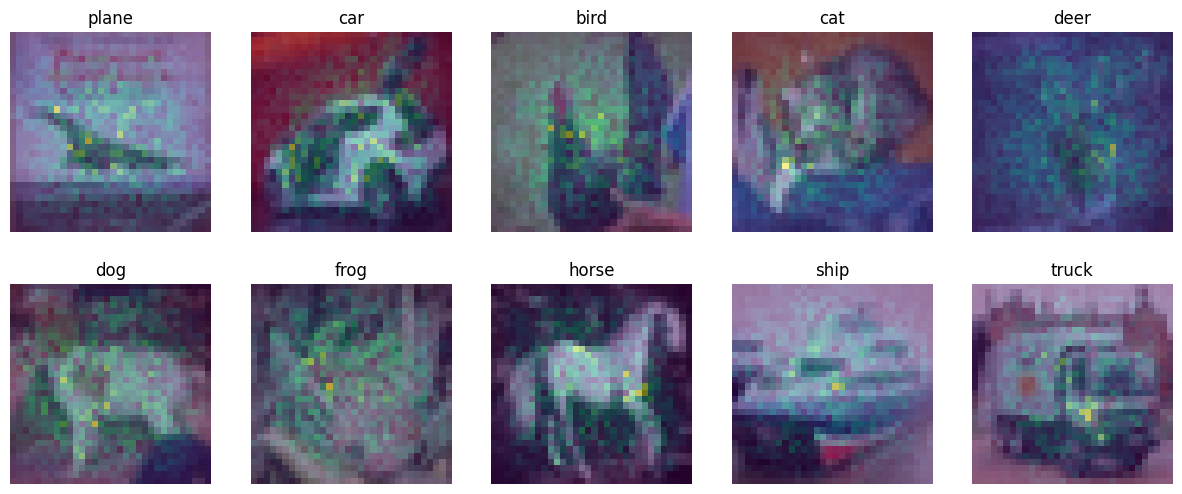

In [33]:
fig, axs = plt.subplots(10,2,figsize=(10, 30))
for i in range(10):
    image=images_per_class[i]
    label=labels_per_class[i]
    smooth_grad=smoothgrad(model22,image,label)
    axs[i,0].imshow(image.permute(1, 2, 0).cpu().numpy()*0.5+0.5)
    axs[i,0].set_title(f"Original: {classes[label]}")
    axs[i,0].axis('off')
    axs[i,1].imshow(np.mean(np.abs(smooth_grad), axis=0), cmap='viridis')
    axs[i,1].set_title(f"SmoothGrad: {classes[label]}")
    axs[i,1].axis('off')
plt.show()